In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import gc   #Gabage collector for cleaning deleted data from memory

#glabl vars

COL_VALUES = ["x", "y", "z","xg","yg","zg"] #input file needs to always have obj as last column
MIN_VALUES = [-200, -200, -200, -10000, -10000, -10000]
MAX_VALUES = [200, 200, 200, 10000, 10000, 10000]

N_CLASSES = 5 #note that objects must be numbered from 0 to N_CLASSES
ROWS = 80 #how many lines per image snapshot
COLS = len(COL_VALUES)
DOWNSIZE_TO = 6000

data=pd.read_csv("data/data_out.csv", names = COL_VALUES + ["obj"])
#print data.loc[200000:200010,COL_VALUES + ["obj"]]


def normalize(df):
    result = df.copy()
    i=0
    for feature_name in COL_VALUES:
        result[feature_name] = (df[feature_name] - MIN_VALUES[i]) / (MAX_VALUES[i] - MIN_VALUES[i])
        i=i+1
    return result

data=normalize(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17844255 entries, 0 to 17844254
Data columns (total 7 columns):
x      float64
y      float64
z      float64
xg     float64
yg     float64
zg     float64
obj    int64
dtypes: float64(6), int64(1)
memory usage: 953.0 MB


number of images after inserting label 0 is 6000
number of images after inserting label 1 is 12000
number of images after inserting label 2 is 18000
number of images after inserting label 3 is 24000
number of images after inserting label 4 is 27914


Text(0.5,1,'labels for objects in processed dataset')

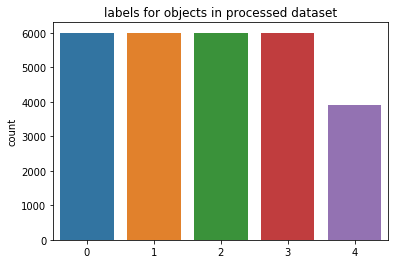

In [87]:
import seaborn as sns

X = [] # images
y = [] # labels

def generate_images(imgs, labels, df, rows, cols, label):
    for i in range(0,min(df.shape[0]-rows, DOWNSIZE_TO*rows),rows):
        imgs.append((df.iloc[i:i+rows,0:cols]).values.tolist())
        labels.append(label)
    print("number of images after inserting label {} is {}".format(label, len(imgs)))
    return

#create the images for each class
for c in range(0, N_CLASSES):
    df=data[data['obj'] == c]
    generate_images(X, y, df, ROWS, COLS, c)
    
#plot labels to doublecheck
sns.countplot(np.array(y))
plt.title('labels for objects in processed dataset')
    

[2 4 3 2 1]


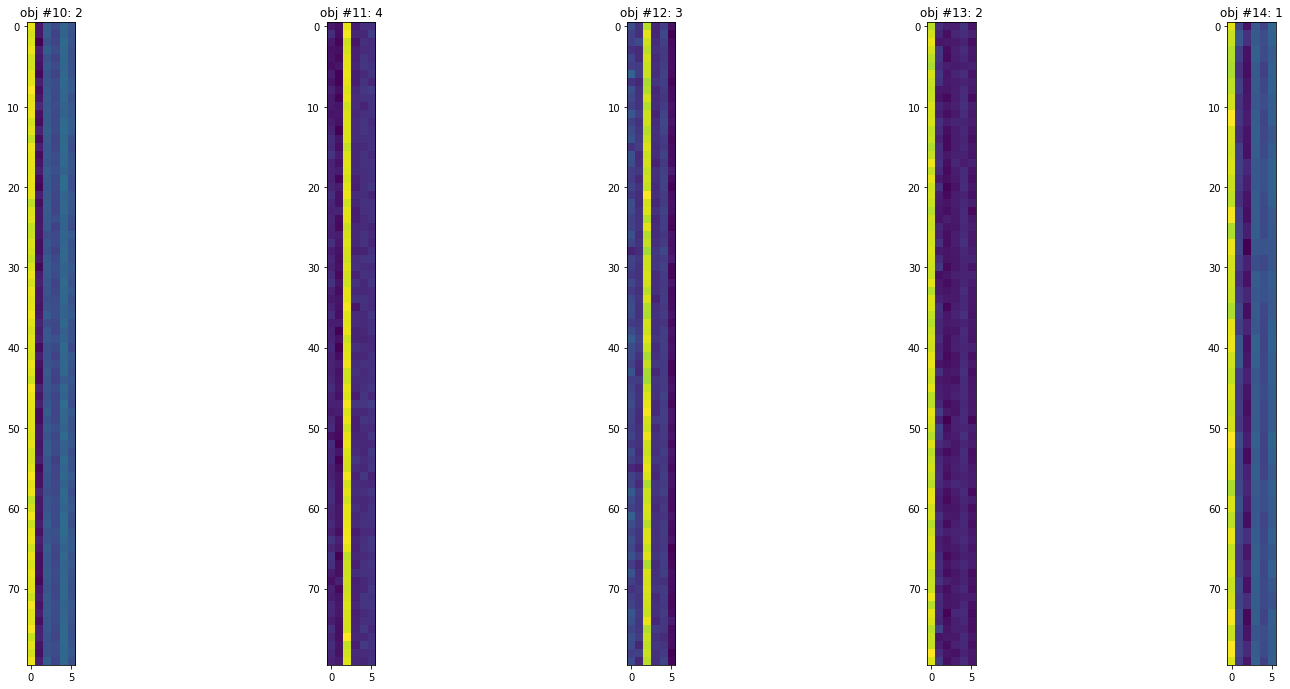

In [90]:
#shuffle and take a look at some random generated images
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def plot5imgs(arr_imgs, arr_labels, random_img):
    plt.figure(figsize=(ROWS/3,ROWS/3))
    columns = 5
    for i in range(columns):
        plt.subplot(5 / columns + 1, columns, i + 1)
        plt.title("obj #{}: {}".format(random_img, arr_labels[random_img]))
        if len(arr_imgs.shape) < 4:
            plt.imshow(arr_imgs[random_img])
        else:
            plt.imshow(arr_imgs[random_img][0])
        random_img=random_img+1


a = []
a = unison_shuffled_copies(np.array(X), np.array(y))
X = a[0]
y = a[1]

num=10
print(y[num:num+5])
plot5imgs(X,y,num)
#X[3000]

In [91]:
#Convert list to numpy array
X = np.array(X)
y = np.array(y)
print("Shape of all images is:", X.shape)
print("Shape of all labels is:", y.shape)

#Lets split the data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.40, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of train labels is:", y_train.shape)
print("Shape of validation labels is:", y_val.shape)

#clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

('Shape of all images is:', (27914, 80, 6))
('Shape of all labels is:', (27914,))
('Shape of train images is:', (16748, 80, 6))
('Shape of validation images is:', (11166, 80, 6))
('Shape of train labels is:', (16748,))
('Shape of validation labels is:', (11166,))


In [92]:
from keras.models import Sequential
from keras.layers import (Activation, Dropout, Flatten, Dense, Convolution2D, MaxPooling2D)
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 128
nb_epoch = 12

# Set random seed
np.random.seed(17)
 
# input image dimensions
img_rows, img_cols = ROWS, COLS
 
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=1),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
 
model = Sequential() 
 
model.add(Convolution2D(32, (3, 3), padding="valid", input_shape=(1, ROWS, COLS)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 78, 4)         320       
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 78, 4)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9984)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1278080   
_________________________________________________________________
activation_13 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 645       
__________

In [93]:
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, N_CLASSES)
Y_val = np_utils.to_categorical(y_val, N_CLASSES)
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)

model.fit(X_train, Y_train,
          batch_size=batch_size, 
          epochs=nb_epoch, verbose=1,
          callbacks=callbacks,
          validation_data=(X_val, Y_val))

Train on 16748 samples, validate on 11166 samples
Epoch 1/20
16748/16748 [==============================] - 29s 2ms/step - loss: 1.0768 - acc: 0.5469 - val_loss: 0.5737 - val_acc: 0.8806
Epoch 2/20
16748/16748 [==============================] - 30s 2ms/step - loss: 0.5830 - acc: 0.7751 - val_loss: 0.3115 - val_acc: 0.8945
Epoch 3/20
16748/16748 [==============================] - 34s 2ms/step - loss: 0.4256 - acc: 0.8365 - val_loss: 0.1995 - val_acc: 0.9411
Epoch 4/20
16748/16748 [==============================] - 31s 2ms/step - loss: 0.3423 - acc: 0.8601 - val_loss: 0.1538 - val_acc: 0.9506
Epoch 5/20
16748/16748 [==============================] - 29s 2ms/step - loss: 0.3095 - acc: 0.8719 - val_loss: 0.1375 - val_acc: 0.9482
Epoch 6/20
16748/16748 [==============================] - 30s 2ms/step - loss: 0.2761 - acc: 0.8829 - val_loss: 0.1059 - val_acc: 0.9495
Epoch 7/20
16748/16748 [==============================] - 29s 2ms/step - loss: 0.2444 - acc: 0.8962 - val_loss: 0.1021 - val_acc

In [94]:
#try predict from the validation set
#note that now Y contains a vector which represents the label. it's not a scalar 1,0 anymore

#plot5imgs(X_val, Y_val, 10)
#plt.imshow(X_val[num+i*20][0])

x = np.expand_dims(X_val[num], axis=0)
#print(x)
accuracy = model.evaluate(x=X_val,y=Y_val,batch_size=32)
print "Accuracy: ", accuracy[1]

model.predict(x)

11166/11166 [==============================] - 9s 836us/step
Accuracy:  0.9897904352498657


array([[4.4689444e-27, 1.0895477e-22, 1.5647263e-25, 7.4428046e-01,
        2.5571957e-01]], dtype=float32)

number of images after inserting label 0 is 6000
number of images after inserting label 1 is 12000
number of images after inserting label 2 is 18000
0: [[2.4288286e-13 9.9999702e-01 2.8937750e-15 2.8730201e-37 2.9697783e-06]]
1: [[1.2389394e-06 1.1775184e-05 9.9924362e-01 6.8044880e-22 7.4339774e-04]]
2: [[2.4190459e-13 9.9999702e-01 2.8353479e-15 3.7305516e-37 2.9822122e-06]]
3: [[1.9625158e-13 9.9999762e-01 1.6354252e-15 1.8922121e-37 2.4059693e-06]]
4: [[1.2383340e-06 1.4339939e-05 9.9917358e-01 5.5709246e-22 8.1074273e-04]]
5: [[8.2928286e-14 9.9999797e-01 7.0586882e-16 1.2442046e-37 2.0660491e-06]]
6: [[9.8586488e-01 1.4575981e-03 1.2392680e-02 7.4757721e-27 2.8475869e-04]]
7: [[9.6616847e-14 9.9999809e-01 7.9560915e-16 7.5311839e-38 1.9292495e-06]]
8: [[9.9539632e-01 1.2345042e-03 3.2746235e-03 4.7613950e-30 9.4474926e-05]]
18000/18000 [==============================] - 17s 920us/step
Accuracy:  0.9996666666666667


1

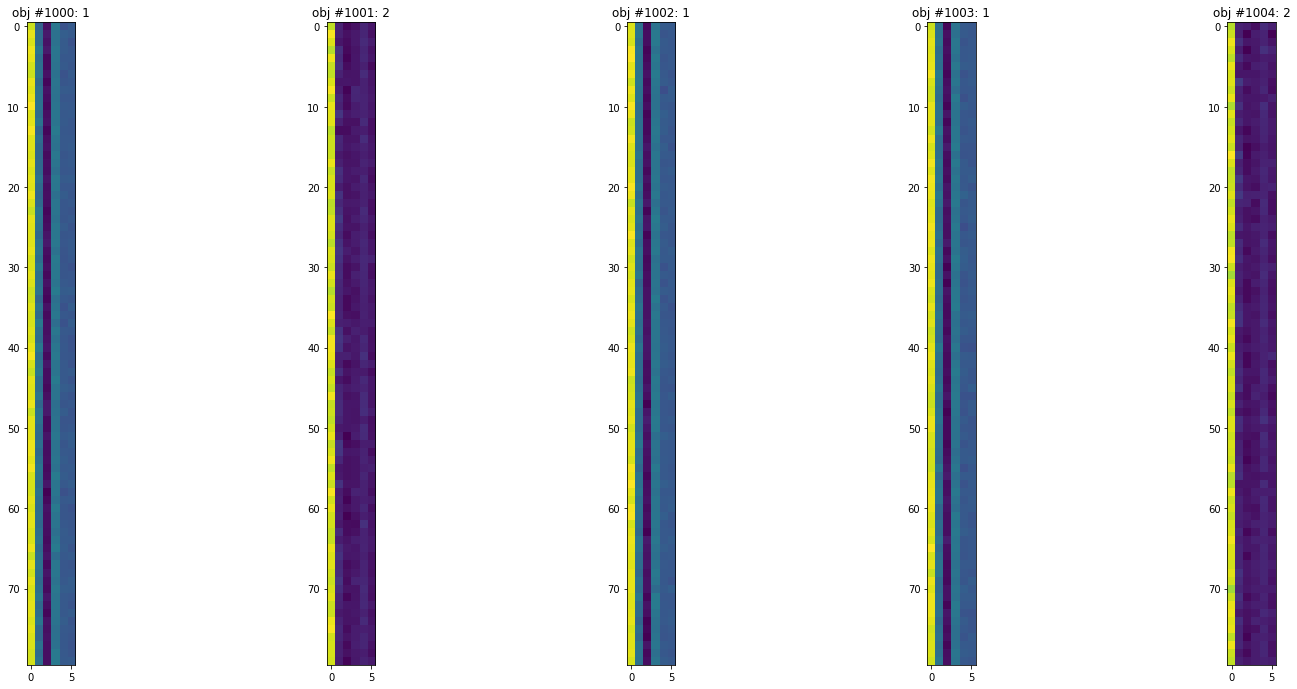

In [107]:
#try predict from external data
data=pd.read_csv("data/data_val.csv", names = COL_VALUES + ["obj"])
data=normalize(data)
X = []
y = []
TEST_CLASSES=3

#create the images for each class
for c in range(0, TEST_CLASSES):
    df=data[data['obj'] == c]
    generate_images(X, y, df, ROWS, COLS, c)

a = []
a = unison_shuffled_copies(np.array(X), np.array(y))
X = a[0]
y = a[1]  

y = np.array(y)
X = np.array(X)


num = 1000
plot5imgs(X,y,num)
for i in range(0,9):
    x = np.expand_dims(X[num+i], axis=0)
    x = np.expand_dims(x, axis=0)
    print "{}: {}".format(i, model.predict(x))
    
y = np_utils.to_categorical(y, N_CLASSES)
X = X.reshape(X.shape[0], 1, img_rows, img_cols)

accuracy = model.evaluate(x=X,y=y,batch_size=16)
#accuracy = model.evaluate(x=X_val,y=Y_val,batch_size=32)
print "Accuracy: ", accuracy[1]

del X
del y
del a
del data
gc.collect()